In [78]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


In [79]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

def preprocess_data(df):
    df.drop(index=[0, 1], inplace=True, errors='ignore')
    if 'Price' in df.columns:
        df.rename(columns={'Price': 'Date'}, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df.dropna(subset=['Date', 'Close'], inplace=True)
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    df.dropna(subset=['Close'], inplace=True)
    
    return df  # ✅ Must return 3 items


In [80]:
def create_sequences(data, time_step=60):
    X = []
    y = []
    
    for i in range(time_step, len(data)):
        X.append(data[i - time_step:i])  # Taking the last 60 days' closing prices
        y.append(data[i])  # Target: the next day's closing price
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y


In [81]:
def build_model(input_shape):
    model = Sequential()

    # Adding LSTM layers with Dropout
    model.add(LSTM(units=100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))  # Dropout layer to prevent overfitting

    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50))
    model.add(Dropout(0.2))

    # Dense layer to output a single value
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    return model


# AAPL

In [82]:
import os,sys
sys.path.append(os.path.abspath('..'))

In [83]:
path = r'C:\Complete Project\Stock-Price-Prediction-using-LSTM\historical_data\AAPL.csv'

In [84]:
data = pd.read_csv(path)

In [85]:
data = preprocess_data(data)

In [86]:
# Extract closing price for simplicity
data = data[['Close']]

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [87]:
# Create sequences of data
X, y = create_sequences(scaled_data)

# Reshape X to be 3D (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [88]:
# Split the data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

In [89]:
# Build the model
model = build_model(X_train.shape[1:])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,  # Number of epochs to train
                    batch_size=32,  # Batch size
                    callbacks=[early_stopping],  # Early stopping callback
                    verbose=1)


Epoch 1/50


C:\Users\POOJA\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0014 - val_loss: 0.0052
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 2.3233e-04 - val_loss: 0.0016
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 2.2936e-04 - val_loss: 0.0059
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 1.6815e-04 - val_loss: 0.0042
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 1.9620e-04 - val_loss: 6.3367e-04
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 1.7193e-04 - val_loss: 7.7121e-04
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 1.1944e-04 - val_loss: 6.4051e-04
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 2.0958e-04 - val_loss: 0.0013
Epoch 9/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 1.1127e-04 - val_loss: 5.0421e-04
Epoch 10/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 1.2670e-04 - val_loss: 0.0072
Epoch 11/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 1.0587e-04 - val_loss: 0.

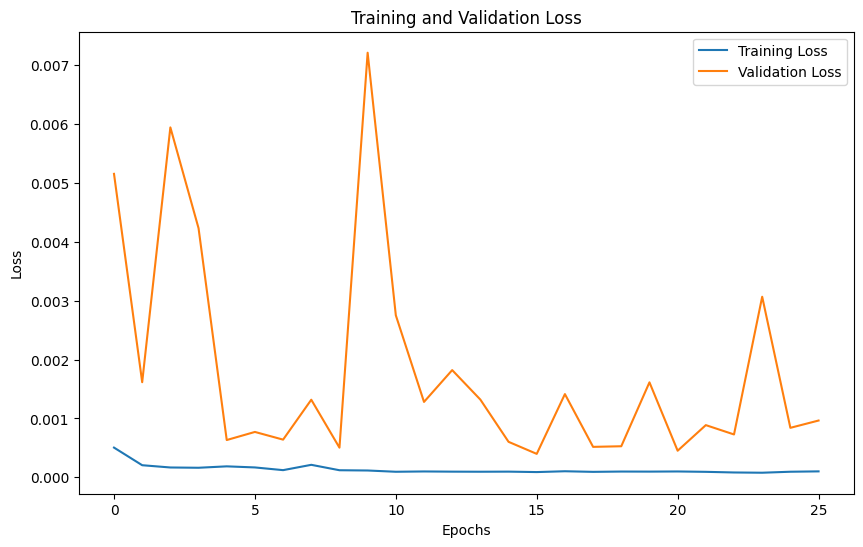

In [90]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [91]:
# Save the trained model
model.save(f'model/AAPL_model.h5')
print("Model saved successfully.")


Model saved successfully.


In [92]:
# Evaluate the model on validation data
val_loss = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.8669e-04
Validation Loss: 0.00039861418190412223


In [93]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model(f'model/AAPL_model.h5')

# Make predictions with the loaded model
loaded_model_predictions = loaded_model.predict(X_val)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


In [94]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Inverse transform the predictions and actual values back to original scale
y_pred = scaler.inverse_transform(loaded_model_predictions)
y_true = scaler.inverse_transform(y_val.reshape(-1, 1))

# Compute evaluation metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Display results
print(f"📉 Mean Squared Error (MSE): {mse:.4f}")
print(f"📉 Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"📉 Mean Absolute Error (MAE): {mae:.4f}")
print(f"📈 R² Score: {r2:.4f}")


📉 Mean Squared Error (MSE): 26.6173
📉 Root Mean Squared Error (RMSE): 5.1592
📉 Mean Absolute Error (MAE): 4.0405
📈 R² Score: 0.9742


C:\Users\POOJA\AppData\Local\Temp\ipykernel_7956\2774469258.py:11: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\POOJA\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


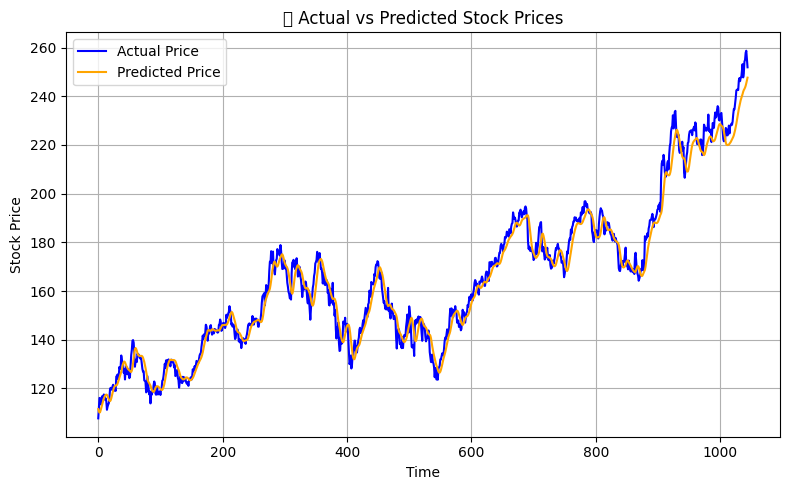

In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(y_true, label='Actual Price', color='blue')
plt.plot(y_pred, label='Predicted Price', color='orange')
plt.title('📈 Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# TSLA

In [96]:
path = r'C:\Complete Project\Stock-Price-Prediction-using-LSTM\historical_data\TSLA.csv'

In [97]:
data = pd.read_csv(path)

In [98]:
data = preprocess_data(data)

In [99]:
# Extract closing price for simplicity
data = data[['Close']]

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [100]:
# Create sequences of data
X, y = create_sequences(scaled_data)

# Reshape X to be 3D (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [101]:
# Split the data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

In [102]:
# Build the model
model = build_model(X_train.shape[1:])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,  # Number of epochs to train
                    batch_size=32,  # Batch size
                    callbacks=[early_stopping],  # Early stopping callback
                    verbose=1)


Epoch 1/50


C:\Users\POOJA\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 8.4240e-04 - val_loss: 0.0029
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 2.0375e-04 - val_loss: 0.0055
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 1.9015e-04 - val_loss: 0.0086
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 1.7730e-04 - val_loss: 0.0039
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 1.5030e-04 - val_loss: 5.8322e-04
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 1.7964e-04 - val_loss: 0.0011
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 1.1690e-04 - val_loss: 0.0020
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 1.3797e-04 - val_loss: 0.0030
Epoch 9/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 1.2998e-04 - val_loss: 6.8200e-04
Epoch 10/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 1.1090e-04 - val_loss: 5.0286e-04
Epoch 11/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 1.2999e-04 - val_loss: 0

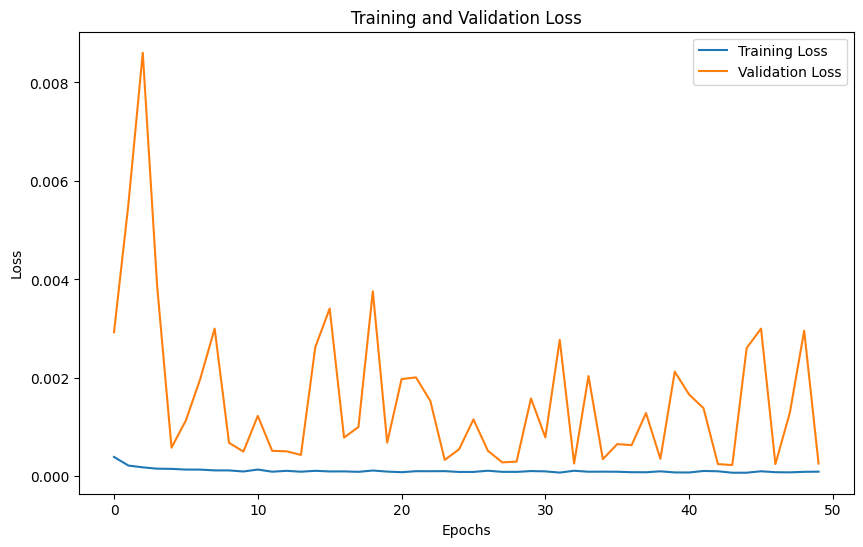

In [103]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [104]:
# Save the trained model
model.save(f'model/TSLA_model.h5')
print("Model saved successfully.")


Model saved successfully.


In [105]:
# Evaluate the model on validation data
val_loss = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.1123e-04
Validation Loss: 0.00022941890347283334


In [106]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model(f'model/TSLA_model.h5')

# Make predictions with the loaded model
loaded_model_predictions = loaded_model.predict(X_val)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [107]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Inverse transform the predictions and actual values back to original scale
y_pred = scaler.inverse_transform(loaded_model_predictions)
y_true = scaler.inverse_transform(y_val.reshape(-1, 1))

# Compute evaluation metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Display results
print(f"📉 Mean Squared Error (MSE): {mse:.4f}")
print(f"📉 Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"📉 Mean Absolute Error (MAE): {mae:.4f}")
print(f"📈 R² Score: {r2:.4f}")


📉 Mean Squared Error (MSE): 15.3193
📉 Root Mean Squared Error (RMSE): 3.9140
📉 Mean Absolute Error (MAE): 3.0436
📈 R² Score: 0.9851


C:\Users\POOJA\AppData\Local\Temp\ipykernel_7956\968185722.py:11: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\POOJA\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


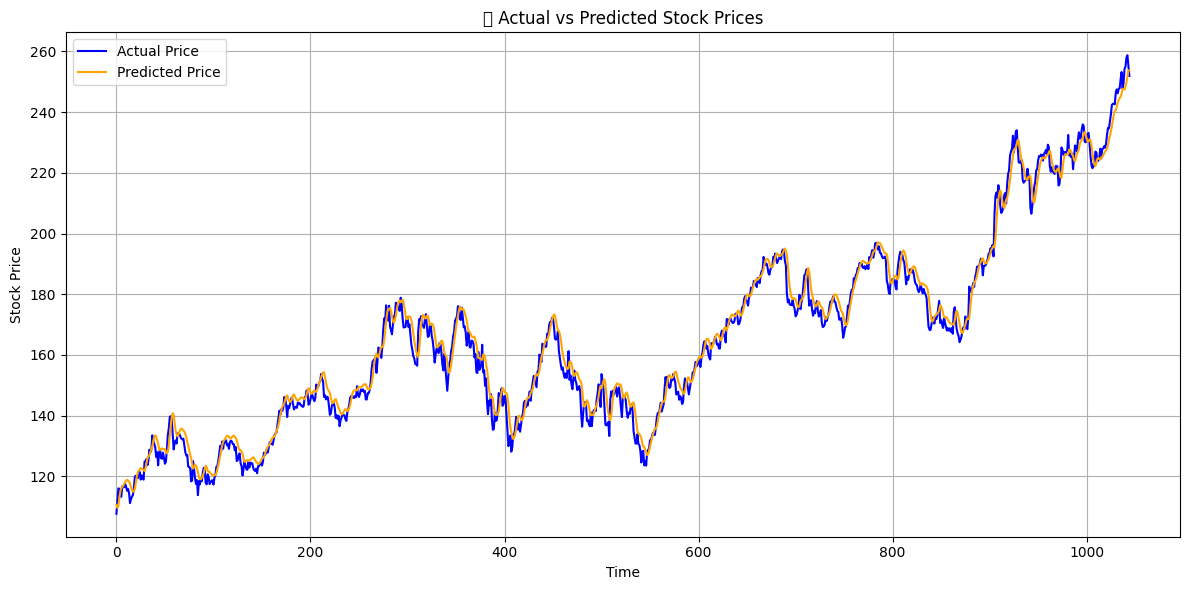

In [108]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Actual Price', color='blue')
plt.plot(y_pred, label='Predicted Price', color='orange')
plt.title('📈 Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# AMZN

In [109]:
import pandas as pd

In [110]:
path =r'C:\Complete Project\Stock-Price-Prediction-using-LSTM\historical_data\AMZN.csv'

In [111]:
data = pd.read_csv(path)

In [112]:
data = preprocess_data(data)

In [113]:
# Extract closing price for simplicity
data = data[['Close']]

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [114]:
# Create sequences of data
X, y = create_sequences(scaled_data)

# Reshape X to be 3D (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [115]:
# Split the data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

In [116]:
# Build the model
model = build_model(X_train.shape[1:])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,  # Number of epochs to train
                    batch_size=32,  # Batch size
                    callbacks=[early_stopping],  # Early stopping callback
                    verbose=1)


Epoch 1/50


C:\Users\POOJA\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 5.1355e-04 - val_loss: 0.0019
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - loss: 4.0378e-04 - val_loss: 0.0029
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - loss: 5.5394e-04 - val_loss: 0.0011
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - loss: 4.5793e-04 - val_loss: 0.0010
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 4.1665e-04 - val_loss: 0.0012
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 3.3006e-04 - val_loss: 0.0011
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - loss: 3.9805e-04 - val_loss: 0.0034
Epoch 9/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - loss: 3.3969e-04 - val_loss: 8.0479e-04
Epoch 10/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 3.9311e-04 - val_loss: 0.0019
Epoch 11/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 4.8770e-04 - val_loss: 0.0010


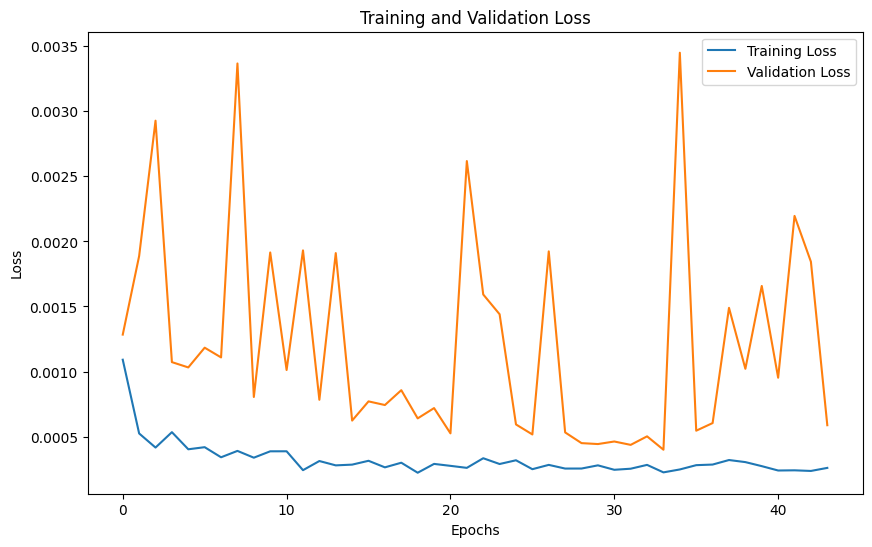

In [117]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [118]:
# Save the trained model
model.save(f'model/AMZN_model.h5')
print("Model saved successfully.")


Model saved successfully.


In [119]:
# Evaluate the model on validation data
val_loss = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.7303e-04
Validation Loss: 0.00039963138988241553


In [121]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model(r'model\AMZN_model.h5')

# Make predictions with the loaded model
loaded_model_predictions = loaded_model.predict(X_val)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


In [122]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Inverse transform the predictions and actual values back to original scale
y_pred = scaler.inverse_transform(loaded_model_predictions)
y_true = scaler.inverse_transform(y_val.reshape(-1, 1))

# Compute evaluation metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Display results
print(f"📉 Mean Squared Error (MSE): {mse:.4f}")
print(f"📉 Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"📉 Mean Absolute Error (MAE): {mae:.4f}")
print(f"📈 R² Score: {r2:.4f}")


📉 Mean Squared Error (MSE): 21.4406
📉 Root Mean Squared Error (RMSE): 4.6304
📉 Mean Absolute Error (MAE): 3.5083
📈 R² Score: 0.9786


C:\Users\POOJA\AppData\Local\Temp\ipykernel_7956\968185722.py:11: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\POOJA\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


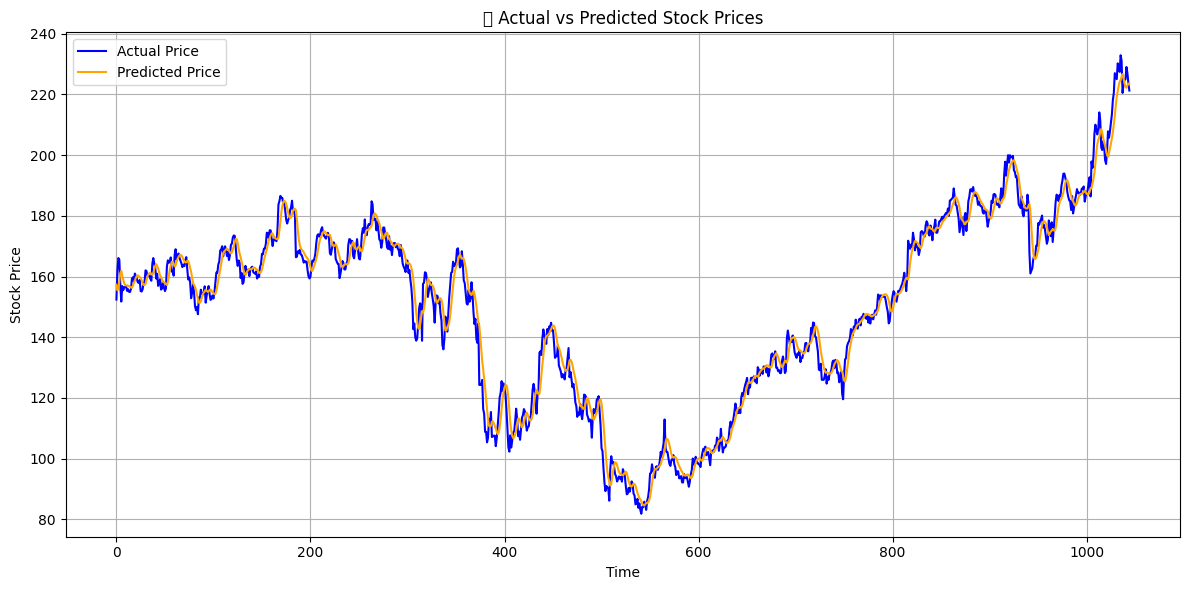

In [123]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Actual Price', color='blue')
plt.plot(y_pred, label='Predicted Price', color='orange')
plt.title('📈 Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# GOOGL

In [124]:
path = r'C:\Complete Project\Stock-Price-Prediction-using-LSTM\historical_data\GOOGL.csv'

In [125]:
data = pd.read_csv(path)

In [126]:
data = preprocess_data(data)

In [127]:
# Extract closing price for simplicity
data = data[['Close']]

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [128]:
# Create sequences of data
X, y = create_sequences(scaled_data)

# Reshape X to be 3D (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [129]:
# Split the data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

In [130]:
# Build the model
model = build_model(X_train.shape[1:])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,  # Number of epochs to train
                    batch_size=32,  # Batch size
                    callbacks=[early_stopping],  # Early stopping callback
                    verbose=1)


Epoch 1/50


C:\Users\POOJA\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - loss: 2.9306e-04 - val_loss: 0.0011
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - loss: 2.5457e-04 - val_loss: 0.0020
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - loss: 2.7415e-04 - val_loss: 0.0013
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - loss: 2.6490e-04 - val_loss: 0.0043
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - loss: 2.0349e-04 - val_loss: 9.1563e-04
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - loss: 2.0903e-04 - val_loss: 0.0010
Epoch 8/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - loss: 1.4045e-04 - val_loss: 0.0011
Epoch 9/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - loss: 1.7942e-04 - val_loss: 7.2907e-04
Epoch 10/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 1.5238e-04 - val_loss: 6.7833e-04
Epoch 11/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 1.4896e-04 - val_loss: 0.0

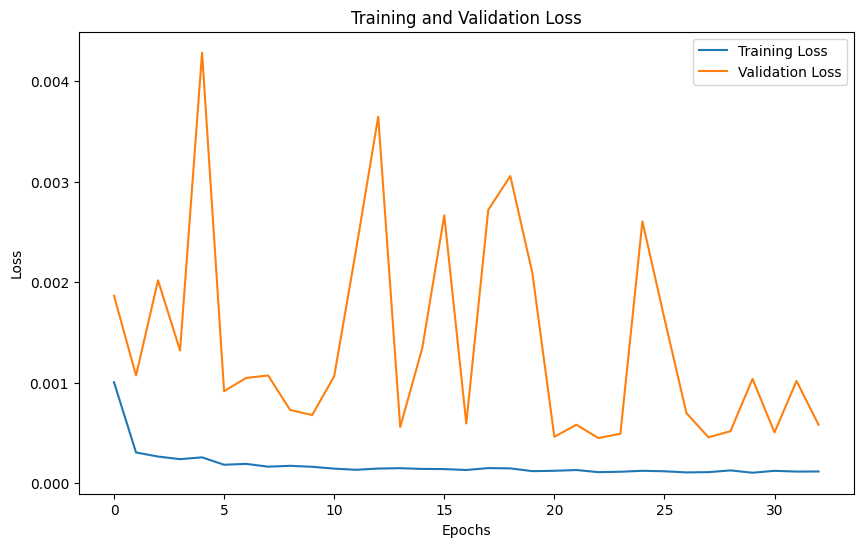

In [131]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [132]:
# Save the trained model
model.save(f'model/GOOGL_model.h5')
print("Model saved successfully.")


Model saved successfully.


In [133]:
# Evaluate the model on validation data
val_loss = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.6094e-04
Validation Loss: 0.00045000071986578405


In [134]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model(f'model/GOOGL_model.h5')

# Make predictions with the loaded model
loaded_model_predictions = loaded_model.predict(X_val)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


In [135]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Inverse transform the predictions and actual values back to original scale
y_pred = scaler.inverse_transform(loaded_model_predictions)
y_true = scaler.inverse_transform(y_val.reshape(-1, 1))

# Compute evaluation metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Display results
print(f"📉 Mean Squared Error (MSE): {mse:.4f}")
print(f"📉 Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"📉 Mean Absolute Error (MAE): {mae:.4f}")
print(f"📈 R² Score: {r2:.4f}")


📉 Mean Squared Error (MSE): 16.9637
📉 Root Mean Squared Error (RMSE): 4.1187
📉 Mean Absolute Error (MAE): 3.1751
📈 R² Score: 0.9745


C:\Users\POOJA\AppData\Local\Temp\ipykernel_7956\968185722.py:11: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\POOJA\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


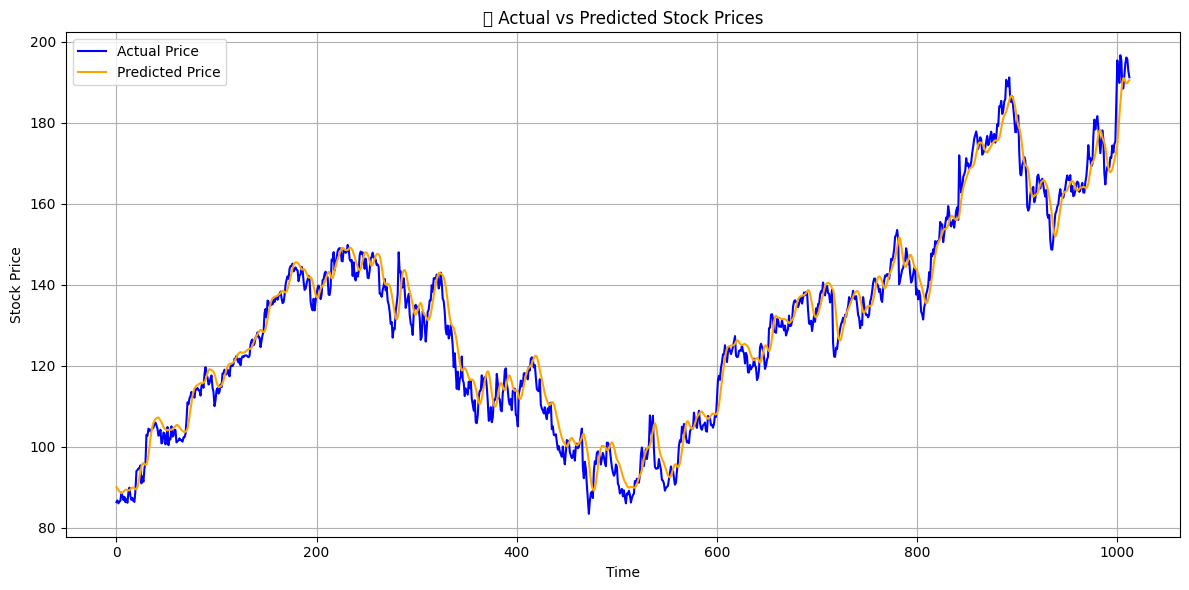

In [136]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Actual Price', color='blue')
plt.plot(y_pred, label='Predicted Price', color='orange')
plt.title('📈 Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# META

In [137]:
path = r'C:\Complete Project\Stock-Price-Prediction-using-LSTM\historical_data\META.csv'

In [138]:
data = pd.read_csv(path)

In [139]:
data = preprocess_data(data)

In [140]:
# Extract closing price for simplicity
data = data[['Close']]

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [141]:
# Create sequences of data
X, y = create_sequences(scaled_data)

# Reshape X to be 3D (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [142]:
# Split the data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

In [143]:
# Build the model
model = build_model(X_train.shape[1:])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,  # Number of epochs to train
                    batch_size=32,  # Batch size
                    callbacks=[early_stopping],  # Early stopping callback
                    verbose=1)


Epoch 1/50


C:\Users\POOJA\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.0083 - val_loss: 0.0025
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 7.7750e-04 - val_loss: 0.0023
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - loss: 8.2584e-04 - val_loss: 0.0015
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - loss: 8.0006e-04 - val_loss: 0.0015
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 6.8683e-04 - val_loss: 0.0013
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 6.2144e-04 - val_loss: 0.0029
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 6.6524e-04 - val_loss: 0.0022
Epoch 8/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 6.6063e-04 - val_loss: 0.0027
Epoch 9/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 6.0664e-04 - val_loss: 0.0013
Epoch 10/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 4.9960e-04 - val_loss: 8.7126e-04
Epoch 11/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - loss: 5.1469e-04 - val_loss: 0.0013
Epoch 12/50
78/78 ━━━━━━━━━━━━

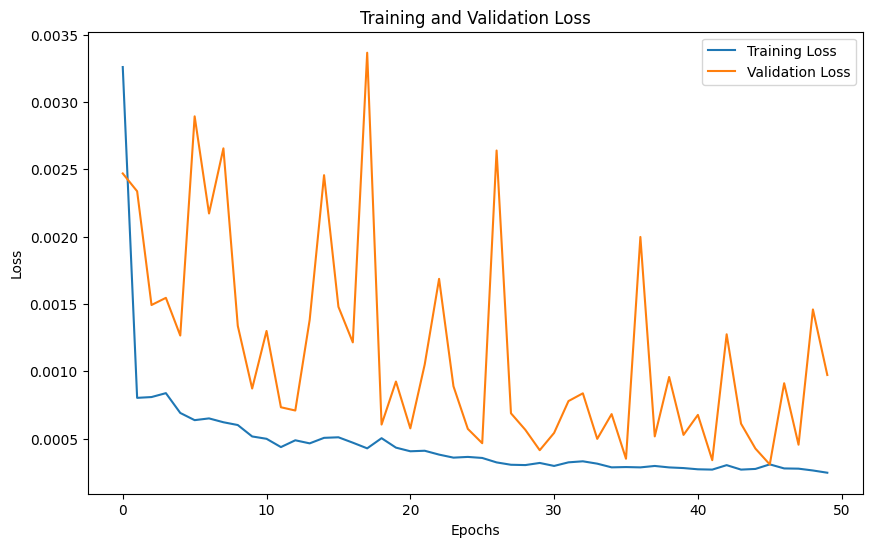

In [144]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [145]:
# Save the trained model
model.save(f'model/META_model.h5')
print("Model saved successfully.")


Model saved successfully.


In [146]:
# Evaluate the model on validation data
val_loss = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.2452e-04
Validation Loss: 0.0003074321721214801


In [147]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model(f'model/META_model.h5')

# Make predictions with the loaded model
loaded_model_predictions = loaded_model.predict(X_val)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


In [148]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Inverse transform the predictions and actual values back to original scale
y_pred = scaler.inverse_transform(loaded_model_predictions)
y_true = scaler.inverse_transform(y_val.reshape(-1, 1))

# Compute evaluation metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Display results
print(f"📉 Mean Squared Error (MSE): {mse:.4f}")
print(f"📉 Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"📉 Mean Absolute Error (MAE): {mae:.4f}")
print(f"📈 R² Score: {r2:.4f}")


📉 Mean Squared Error (MSE): 116.2596
📉 Root Mean Squared Error (RMSE): 10.7824
📉 Mean Absolute Error (MAE): 7.5537
📈 R² Score: 0.9954


C:\Users\POOJA\AppData\Local\Temp\ipykernel_7956\968185722.py:11: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\POOJA\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


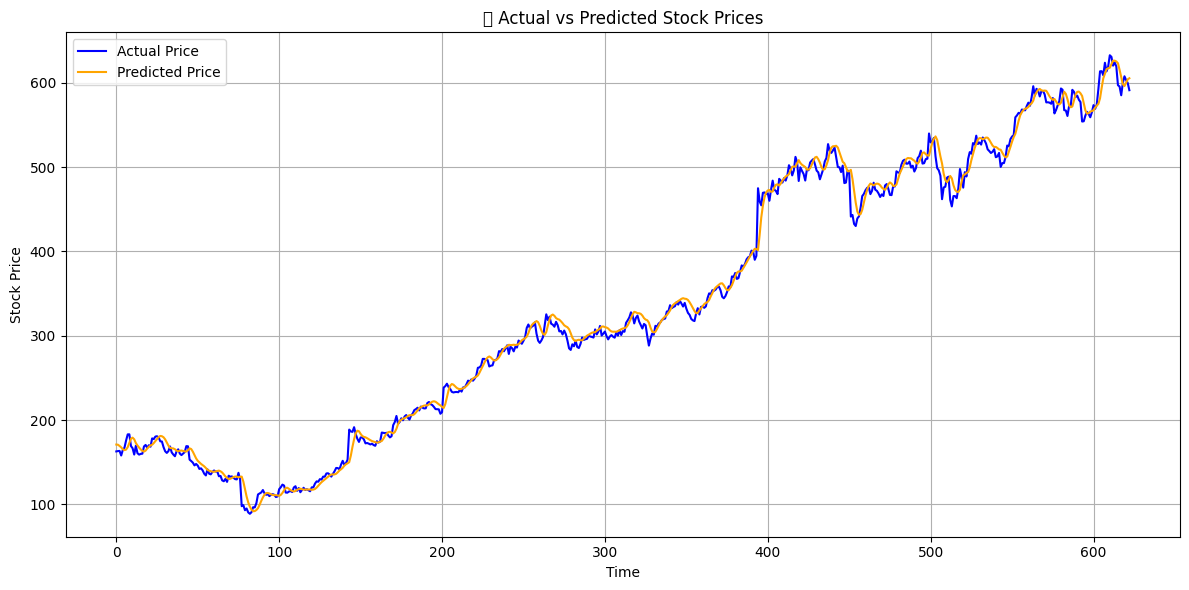

In [149]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Actual Price', color='blue')
plt.plot(y_pred, label='Predicted Price', color='orange')
plt.title('📈 Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# MSFT

In [150]:
path = r'C:\Complete Project\Stock-Price-Prediction-using-LSTM\historical_data\MSFT.csv'

In [151]:
data = pd.read_csv(path)

In [152]:
data = preprocess_data(data)

In [153]:
# Extract closing price for simplicity
data = data[['Close']]

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [154]:
# Create sequences of data
X, y = create_sequences(scaled_data)

# Reshape X to be 3D (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [155]:
# Split the data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

In [156]:
# Build the model
model = build_model(X_train.shape[1:])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,  # Number of epochs to train
                    batch_size=32,  # Batch size
                    callbacks=[early_stopping],  # Early stopping callback
                    verbose=1)


Epoch 1/50


C:\Users\POOJA\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - loss: 0.0013 - val_loss: 0.0128
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - loss: 4.7430e-04 - val_loss: 0.0011
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 1.9091e-04 - val_loss: 0.0028
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - loss: 1.5408e-04 - val_loss: 8.6529e-04
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - loss: 1.7892e-04 - val_loss: 0.0019
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - loss: 1.6459e-04 - val_loss: 0.0039
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - loss: 1.2811e-04 - val_loss: 0.0018
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - loss: 1.2941e-04 - val_loss: 0.0054
Epoch 9/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - loss: 1.4691e-04 - val_loss: 8.1494e-04
Epoch 10/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - loss: 1.5149e-04 - val_loss: 6.2664e-04
Epoch 11/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - loss: 1.2647e-04 - val_lo

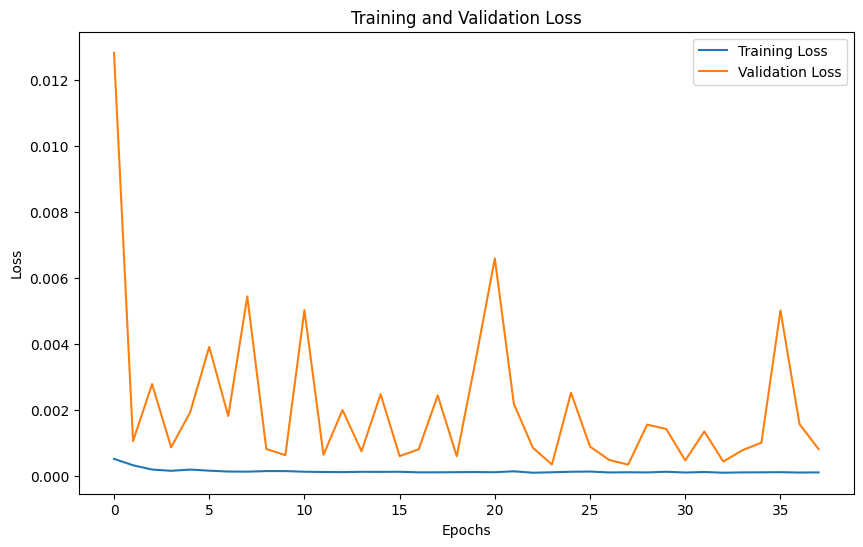

In [157]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [158]:
# Save the trained model
model.save(f'model/MSFT_model.h5')
print("Model saved successfully.")


Model saved successfully.


In [159]:
# Evaluate the model on validation data
val_loss = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.4598e-04
Validation Loss: 0.00033978745341300964


In [160]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model(f'model/MSFT_model.h5')

# Make predictions with the loaded model
loaded_model_predictions = loaded_model.predict(X_val)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [161]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Inverse transform the predictions and actual values back to original scale
y_pred = scaler.inverse_transform(loaded_model_predictions)
y_true = scaler.inverse_transform(y_val.reshape(-1, 1))

# Compute evaluation metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Display results
print(f"📉 Mean Squared Error (MSE): {mse:.4f}")
print(f"📉 Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"📉 Mean Absolute Error (MAE): {mae:.4f}")
print(f"📈 R² Score: {r2:.4f}")


📉 Mean Squared Error (MSE): 69.5459
📉 Root Mean Squared Error (RMSE): 8.3394
📉 Mean Absolute Error (MAE): 6.5570
📈 R² Score: 0.9858


C:\Users\POOJA\AppData\Local\Temp\ipykernel_7956\2774469258.py:11: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


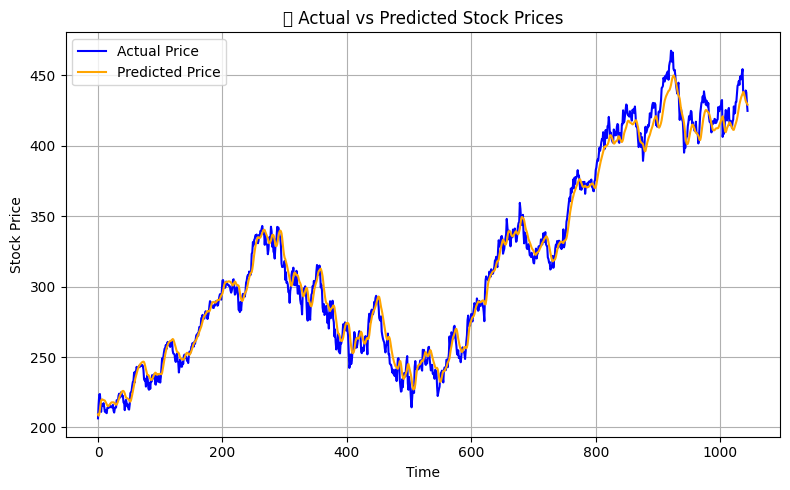

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(y_true, label='Actual Price', color='blue')
plt.plot(y_pred, label='Predicted Price', color='orange')
plt.title('📈 Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')  
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# RESULT

| Ticker    | Val Loss | MSE    | RMSE  | MAE  | R² Score |
| --------- | -------- | ------ | ----- | ---- | -------- |
| **AAPL**  | 0.00040  | 26.62  | 5.16  | 4.04 | 0.9742   |
| **TSLA**  | 0.00023  | 15.32  | 3.91  | 3.04 | 0.9851   |
| **AMZ**   | 0.00040  | 21.44  | 4.63  | 3.51 | 0.9786   |
| **GOOGL** | 0.00045  | 16.96  | 4.12  | 3.18 | 0.9745   |
| **META**  | 0.00031  | 116.26 | 10.78 | 7.55 | 0.9954   |
| **MSFT**  | 0.00034  | 69.55  | 8.34  | 6.56 | 0.9858   |
